<h1>Geocoding Notebook - Sierra Leone<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span></li><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-geoboundaries-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-geoboundaries-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to geoboundaries Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-FEWS-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-FEWS-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to FEWS Adm 2</a></span></li></ul></li></ul></li><li><span><a href="#Match-to-locations-from-alternative-sources-based-on-facility-name" data-toc-modified-id="Match-to-locations-from-alternative-sources-based-on-facility-name-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Match to locations from alternative sources based on facility name</a></span><ul class="toc-item"><li><span><a href="#Health-Sites-IO" data-toc-modified-id="Health-Sites-IO-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Health Sites IO</a></span></li><li><span><a href="#RHINoVision-Master-Facility-List-Decision-Support-System" data-toc-modified-id="RHINoVision-Master-Facility-List-Decision-Support-System-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RHINoVision Master Facility List Decision Support System</a></span></li></ul></li><li><span><a href="#Geocoding-with-APIs" data-toc-modified-id="Geocoding-with-APIs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Geocoding with APIs</a></span><ul class="toc-item"><li><span><a href="#Facility-name-and-admin-3-names" data-toc-modified-id="Facility-name-and-admin-3-names-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Facility name and admin 3 names</a></span></li><li><span><a href="#Facility-name-and-admin-2-names" data-toc-modified-id="Facility-name-and-admin-2-names-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Facility name and admin 2 names</a></span></li><li><span><a href="#Admin-3-names" data-toc-modified-id="Admin-3-names-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Admin 3 names</a></span></li><li><span><a href="#Admin-3--and-admin-2-names" data-toc-modified-id="Admin-3--and-admin-2-names-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Admin 3  and admin 2 names</a></span></li></ul></li><li><span><a href="#Map-and-save-results" data-toc-modified-id="Map-and-save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Map and save results</a></span><ul class="toc-item"><li><span><a href="#Join-attributes-from-adminsitrative-polygons" data-toc-modified-id="Join-attributes-from-adminsitrative-polygons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Join attributes from adminsitrative polygons</a></span></li></ul></li></ul></div>

Version: January 23, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources for health POI data, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
from geopy.geocoders import GeoNames, Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
from thefuzz import fuzz
from thefuzz import process
import matplotlib.pyplot as plt
from string import ascii_uppercase
import contextily as ctx
from os.path import join
import numpy as np
from dotenv import load_dotenv, find_dotenv

In [2]:
def remove_words(data_frame, column_name, words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']):
    """ Remove words from strings in a specified column
    
    Args:
        data_frame: Pandas data frame
        column_name: Column name to remove words from
        words_to_remove: List of words

    Returns:
        Removes words in place

    """
    for word in words_to_remove:
        data_frame[column_name] = data_frame[column_name].str.replace(word, "")
    data_frame[column_name] = data_frame[column_name].str.strip()
        
def report_geocoding(records):
    """ Report value counts and % from geocoding_method column.
    
    Args:
        records: Pandas data frame

    Returns:
        Table with count stats 
    """
    table = records[['NAME', 'geocoding_method']].groupby('geocoding_method').count().rename(columns={'NAME':'count'})
    table.loc[:, "pct"] = table/(table['count'].sum())
    table = table.style.format({
        'pct': '{:,.1%}'.format,
    })
    return(table)

def match_name(name, list_names, min_score=0):
    """ Uses fuzzy matching between one string and a list of candidate names.
    
    Args:
        name: string
        list_names: list of candidate names to match
        min_score: minimum score allowed

    Returns:
        Returns name with the highest match, and match score
        If no match is higher than min score, returns "" and -1
    """
    # -1 score incase we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iterating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

def match_to_closest(row, gdf, column='ADMIN2'):
    """ Spatial join using closest distance algorithm.
    
    Args:
        row: row from geo data frame
        gdf: gdf with attributes to join
        column: attribute to join

    Returns:
        Returns specified attribute of closest feature
    """
    distances = [row.geometry.distance(pol) for pol in gdf.geometry]
    min_id = np.argmin(distances)
    closest = gdf.iloc[min_id]
    return closest[column]

def run_geocoding(idx, row, master_table, admin_area, components, country_code):
    """
    Geocoding workflow to be applied to each row in a dataset
    
    Args:
        idx: index
        row: row with index and names to geocode
        master_table: master table to store results
        admin_area: gdf of admin area to ensure result falls within
        components: list of names of attributes to use in query
        country_code: two letter iso code
    
    Returns:
        Stores geocoding results in master_table object
    """
    admin_bounds = admin_area.bounds
    bb = [(admin_bounds.iloc[0].miny, admin_bounds.iloc[0].minx), (admin_bounds.iloc[0].maxy, admin_bounds.iloc[0].maxx)]
    method = ' and '.join(components)
    items = [row[item] for item in components]
    query = ', '.join(items)
    
    geocoding_result = None
    geocoding_method = "None"
    # Try Geocoding with OSM
    try:
        res = geolocator_osm.geocode(query, country_codes=country_code)
        # if within admin
        if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
            geocoding_result = res
            geocoding_method = f"{method} query OSM"
        else:
            raise Exception("OSM point not valid or not within polygon")
    except:
        # Try Geocoding with Bing Maps
        try:
            res = geolocator_bing.geocode(query)
            # if within admin
            if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                geocoding_result = res
                geocoding_method = f"{method} query Bing"
            else:
                raise Exception("Bing point not valid or not within polygon")
        except:
            # Try Geocoding with Google
            try:
                res = geolocator_google.geocode(query = query, region = country_code, bounds = bb)
                if res:
                    # if within admin
                    if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                        geocoding_result = res
                        geocoding_method = f"{method} query Google"
            except:
                raise Exception("Google point not valid or not within polygon")
    
    master_table.loc[idx, "geocoding_method"] = geocoding_method
    if geocoding_result:
        master_table.loc[idx, "longitude"] = res.longitude
        master_table.loc[idx, "latitude"] = res.latitude

In [4]:
iso3 = "SLE"
country = "Sierra Leone"
input_dir = "/home/public/Data/PROJECTS/Health" 
output_dir = join(input_dir, "output")
# if not os.path.exists(out_folder):
#     os.mkdir(out_folder)

# Prepare and match admin boundary data 

In [5]:
geob4 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM4/geoBoundaries-{iso3}-ADM4.geojson")
geob3 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM3/geoBoundaries-{iso3}-ADM3.geojson")
geob2 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM2/geoBoundaries-{iso3}-ADM2.geojson")
geob1 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM1/geoBoundaries-{iso3}-ADM1.geojson")
fews2 = gpd.read_file(join(input_dir, 'FEWS', 'SLE', 'SL_Admin2_2017.shp'))

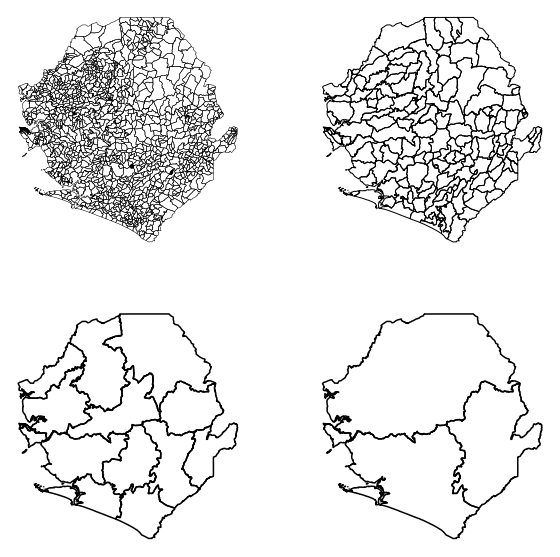

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
geob4.boundary.plot(ax=ax[0, 0], color='black', linewidth=0.5).set_axis_off()
geob3.boundary.plot(ax=ax[0, 1], color='black', linewidth=1).set_axis_off()
geob2.boundary.plot(ax=ax[1, 0], color='black').set_axis_off()
geob1.boundary.plot(ax=ax[1, 1], color='black').set_axis_off()
# plt.axis('off')

In [7]:
master_table = pd.read_csv(os.path.join(input_dir, "tom_formatted", "hierarchy", "tom_edited_sierraleone_collapsed.csv"), encoding='utf-8')

In [8]:
master_table.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5
0,Sierra Leone,Bo District,Bo City Council,Bo City,Aethel
1,Sierra Leone,Bo District,Bo City Council,Bo City,Agape Way


In [9]:
len(master_table)

1564

In [10]:
print(f"Unique Level 2: {len(master_table.orgunitlevel2.unique())}")
print(f"Unique Level 3: {len(master_table.orgunitlevel3.unique())}")
print(f"Unique Level 4: {len(master_table.orgunitlevel4.unique())}")
print(f"Unique Level 5: {len(master_table.orgunitlevel5.unique())}")

Unique Level 2: 16
Unique Level 3: 22
Unique Level 4: 208
Unique Level 5: 1556


In [11]:
print(f"Unique Geoboundaries Adm 1: {len(geob1)}")
print(f"Unique Geoboundaries Adm 2: {len(geob2)}")
print(f"Unique Geoboundaries Adm 3: {len(geob3)}")
print(f"Unique Geoboundaries Adm 4: {len(geob4)}")

Unique Geoboundaries Adm 1: 4
Unique Geoboundaries Adm 2: 14
Unique Geoboundaries Adm 3: 165
Unique Geoboundaries Adm 4: 1322


## Match health list admin names to shapefile admin names
### Match orgunitlevel4 to geoboundaries Adm 3
Try using fuzzy matching  

In [13]:
level4_list = list(master_table.orgunitlevel4.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

Print names to inspect

In [14]:
for letter in ascii_uppercase:
    level4_sublist = [name for name in level4_list if name[0]==letter]
    geob3_sublist = [name for name in geob3_list if name[0]==letter]

    if len(level4_sublist)>0:
        print("Master list level 4")
        print("\t"+str(level4_sublist))
    if len(geob3_sublist) >0:
        print("Geoboundaries adm3")
        print("\t"+str(geob3_sublist))
        
    print("\n")



Master list level 4
	['Badjia', 'Bagbwe', 'Bagruwa', 'Bake-Loko', 'Baoma', 'Barawa Wollay', 'Bargbo', 'Barri', 'Bendu-Cha', 'Biriwa', 'Bo City', 'Bombali Sebora', 'Bombali Serry', 'Bongor', 'Bonthe Town', 'Bramaia', 'Bum', 'Bumpe Ngao', 'Bumpeh', 'Bureh', 'Buya']
Geoboundaries adm3
	['Badjia', 'Bagbo', 'Bagbwe(Bagbe)', 'Bagruwa', 'Barri', 'Bendu-Cha', 'Biriwa', 'Bo Town', 'Boama', 'Bombali Sebora', 'Bonthe Urban', 'Bramaia', 'Bum', 'Bumpe Ngao', 'Bumpeh', 'Bureh Kasseh Ma', 'Buya Romende']


Master list level 4
	['Central 1 Zone', 'Central 2 Zone']
Geoboundaries adm3
	['Central I', 'Central II']


Master list level 4
	['Dama', 'Dansogoia', 'Dasse', 'Dea', 'Delmandugu', 'Dema', 'Dembelia-Sinkunia', 'Diang', 'Dibia', 'Dixon', 'Dodo']
Geoboundaries adm3
	['Dama', 'Dasse', 'Dea', 'Dema', 'Dembelia - Sink', 'Diang', 'Dibia', 'Dodo']


Master list level 4
	['East 1 Zone', 'East 2 Zone', 'East 3 Zone']
Geoboundaries adm3
	['East I', 'East II', 'East III']


Master list level 4
	['Fakunya', 

Manually adjust spellings of master health list to create more matches.

In [15]:
master_table.loc[:, "orgunitlevel4_edit"] = master_table.orgunitlevel4

In [16]:
# master_table.loc[master_table.orgunitlevel4 == "Bo City", "orgunitlevel4_edit"] = "Bo Town"
master_table.loc[master_table.orgunitlevel4 == "Central 1 Zone", "orgunitlevel4_edit"] = "Central I"
master_table.loc[master_table.orgunitlevel4 == "Central 2 Zone", "orgunitlevel4_edit"] = "Central II"
master_table.loc[master_table.orgunitlevel4 == "East 1 Zone", "orgunitlevel4_edit"] = "East I"
master_table.loc[master_table.orgunitlevel4 == "East 2 Zone", "orgunitlevel4_edit"] = "East II"
master_table.loc[master_table.orgunitlevel4 == "East 3 Zone", "orgunitlevel4_edit"] = "East III"
master_table.loc[master_table.orgunitlevel4 == "West 1 Zone", "orgunitlevel4_edit"] = "West I"
master_table.loc[master_table.orgunitlevel4 == "West 2 Zone", "orgunitlevel4_edit"] = "West II"
master_table.loc[master_table.orgunitlevel4 == "West 3 Zone", "orgunitlevel4_edit"] = "West III"
master_table.loc[master_table.orgunitlevel4 == "Bagbwe", "orgunitlevel4_edit"] = "Bagbwe(Bagbe)"

Remove key words that confuse matching algorithm

In [17]:
remove_words(geob3, "shapeName", ['Town', 'City', 'Urban', 'Zone'])
remove_words(master_table, "orgunitlevel4_edit", ['Town', 'City', 'Urban', 'Zone'])

In [18]:
# level4_list = list(master_table.orgunitlevel4.unique())
level4_list = list(master_table.orgunitlevel4_edit.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

In [19]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in level4_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob3_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level4" : name})
    dict_.update({"name_geob3" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm3 = pd.DataFrame(dict_list)
table_adm3_matches = table_adm3[table_adm3.score > 70].copy()

In [20]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'78.37%'

In [21]:
# could save this list for someone to confirm matches manually
# for now take input noting which ones should be dropped based on quick inspection
table_adm3_matches.loc[table_adm3_matches.score<=80]

,name_level4,name_geob3,score
4,Baoma,Boama,80
13,Bongor,Mongo,73
19,Bureh,Bumpeh,73
24,Dansogoia,Kalansogoia,80
40,Folosaba Kamba,Folosaba Dembel,76
42,Galliness,Galliness Perri,75
47,Gbanti (Karene),Gbanti Kamarank,73
48,Gbendembu,Gbendembu Ngowa,75
54,Gbokolenken Polie,Gbonkolenken,76
55,Gbokolenken Yele,Gbonkolenken,79


In [22]:
for idx, row in table_adm3_matches.loc[table_adm3_matches.score<=80].iterrows():
    print(row)
    print('\n')
    drop_input = input("Drop? If no, leave blank: ")
    if len(drop_input)>0:
        table_adm3_matches.drop(idx, axis=0, inplace=True)

name_level4    Baoma
name_geob3     Boama
score             80
Name: 4, dtype: object


Drop? If no, leave blank: 
name_level4    Bongor
name_geob3      Mongo
score              73
Name: 13, dtype: object


Drop? If no, leave blank: yes
name_level4     Bureh
name_geob3     Bumpeh
score              73
Name: 19, dtype: object


Drop? If no, leave blank: yes
name_level4      Dansogoia
name_geob3     Kalansogoia
score                   80
Name: 24, dtype: object


Drop? If no, leave blank: yes
name_level4     Folosaba Kamba
name_geob3     Folosaba Dembel
score                       76
Name: 40, dtype: object


Drop? If no, leave blank: 
name_level4          Galliness
name_geob3     Galliness Perri
score                       75
Name: 42, dtype: object


Drop? If no, leave blank: 
name_level4    Gbanti (Karene)
name_geob3     Gbanti Kamarank
score                       73
Name: 47, dtype: object


Drop? If no, leave blank: 
name_level4          Gbendembu
name_geob3     Gbendembu Ngowa
scor

In [23]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'74.04%'

### Match orgunitlevel3 to FEWS Adm 2

In [24]:
master_table.loc[:, "orgunitlevel2_edit"] = master_table.orgunitlevel2

In [25]:
# remove_words(geob2, "admin2Name", [" City Council", " District Council", " Municipal Council"])
remove_words(master_table, "orgunitlevel2_edit", [" District"])
remove_words(fews2, "ADMIN2", [" City Council", " District Council", " Municipal Council"])

In [26]:
level2_list = list(master_table.orgunitlevel2_edit.unique())
level2_list.sort()
geob2_list = list(geob2.admin2Name)
geob2_list.sort()
fews2_list = list(fews2.ADMIN2)
fews2_list.sort()

In [27]:
for letter in ascii_uppercase:
    level2_sublist = [name for name in level2_list if name[0]==letter]
    geob2_sublist = [name for name in geob2_list if name[0]==letter]
    fews2_sublist = [name for name in fews2_list if name[0]==letter]
    if len(level2_sublist)>0:
        print("Master list level 2")
        print("\t"+str(level2_sublist))
#     if len(geob2_sublist) >0:
#         print("Geoboundaries adm2")
#         print("\t"+str(geob2_sublist))
    if len(fews2_sublist) >0:
        print("FEWS adm2")
        print("\t"+str(fews2_sublist))
    print("\n")



Master list level 2
	['Bo', 'Bombali', 'Bonthe']
FEWS adm2
	['Bo', 'Bombali', 'Bonthe']








Master list level 2
	['Falaba']
FEWS adm2
	['Falaba']










Master list level 2
	['Kailahun', 'Kambia', 'Karene', 'Kenema', 'Koinadugu', 'Kono']
FEWS adm2
	['Kailahun', 'Kambia', 'Karene', 'Kenema', 'Koinadugu', 'Kono']




Master list level 2
	['Moyamba']
FEWS adm2
	['Moyamba']






Master list level 2
	['Port Loko', 'Pujehun']
FEWS adm2
	['Port Loko', 'Pujehun']








Master list level 2
	['Tonkolili']
FEWS adm2
	['Tonkolili']






Master list level 2
	['Western Area Rural', 'Western Area Urban']
FEWS adm2
	['Western Area Rural', 'Western Area Urban']










In [28]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in level2_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, fews2_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level2" : name})
    dict_.update({"name_fews2" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm2 = pd.DataFrame(dict_list)
table_adm2_matches = table_adm2[table_adm2.score > 75]

In [29]:
matches_pct = (len(table_adm2_matches) / len(level2_list))
'{:.2f}%'.format(matches_pct*100)

'100.00%'

Loop through each row in master table, and add new attribute names (adm3 and adm2), if the names produced matches in the lookup tables

In [30]:
master_table_copy = master_table.copy()

In [31]:
for idx, row in master_table_copy.iterrows():
    
    if row.orgunitlevel4_edit in list(table_adm3_matches.name_level4):
        
        match = table_adm3_matches.loc[table_adm3_matches.name_level4==row.orgunitlevel4_edit, "name_geob3"].iloc[0]
        master_table_copy.loc[idx, 'adm3'] = match
        
    if row.orgunitlevel2_edit in list(table_adm2_matches.name_level2):
        
        match = table_adm2_matches.loc[table_adm2_matches.name_level2==row.orgunitlevel2_edit, "name_fews2"].iloc[0]
        master_table_copy.loc[idx, 'adm2'] = match

In [32]:
master_table_copy.adm2.isna().sum()

0

In [33]:
master_table_copy.adm3.isna().sum()

246

In [34]:
master_table_copy.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel4_edit,orgunitlevel2_edit,adm3,adm2
0,Sierra Leone,Bo District,Bo City Council,Bo City,Aethel,Bo,Bo,Bo,Bo
1,Sierra Leone,Bo District,Bo City Council,Bo City,Agape Way,Bo,Bo,Bo,Bo


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.  
In QGIS, I created centroids from the ways then merged it with the points.

In [51]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", "SLE", "merged_SLR_healthsites_pts.shp"))

In [52]:
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()

In [53]:
nodes_io['name'] = nodes_io['name'].str.lower()

In [54]:
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']

In [55]:
records = master_table_copy.copy()
records['NAME'] = records['orgunitlevel5'].str.lower()

In [56]:
remove_words(nodes_io, 'name', words_to_remove)
remove_words(records, 'NAME', words_to_remove)

In [57]:
records['geocoding_method'] = "None"

In [58]:
for idx, row in tqdm(records.iterrows()):
    
    # Check if there is another entry with location
    match, score = match_name(row.NAME, list(nodes_io['name']), 75)
#     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)
    
    if score > 0:
        print(row.NAME, match)
        matching_row = nodes_io.loc[nodes_io['name']==match].copy()
        res = matching_row.iloc[0]
        
        if not pd.isna(row.adm3):
            adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
            if adm3.contains(res.geometry).values[0] == True:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO"
        else:
            adm2 = geob2.loc[geob2['admin2Name'] == row['adm2']].copy() if row.adm2 in geob2_list else fews2.loc[fews2['ADMIN2'] == row['adm2']].copy()
            if adm2.contains(res.geometry).values[0] == True:            
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO"

122it [00:00, 610.81it/s]

edc unit edc unit
nafaya nafaya
kakama makama
gbaama gbahama
bo childrens children's
maguama makama
gbangba rogbangba


234it [00:00, 578.32it/s]

gboyama boama
makama makama
panlap panlap
stocco stocco
mambala amalan
makaiba makama
magbenteh magbenteh
manewa manowa
mara mahera
holy spirit holy spirit
loreto loreto
teko barracks teko barracks


410it [00:00, 567.50it/s]

bonthe bonthe
fullamansa fulamansa
bandapirie bandapirie
durukoro durukoro mchp
seria seria
walia talia
koindu kura koindu kutay
dia dia
foidu koidu
koindu koindu
madopolahun madopolahun
kailahun kailahun
jojoima jojoima


518it [00:00, 535.77it/s]

mobai mobai
manowa manowa
bendu bendugu
kukuna kukuna
fodaya fodaya
magbengbeh magbengeh
barakuya barukuya
magbethy magbenteh
rokupr rokupa


704it [00:01, 582.54it/s]

timbo tombo
sendugu bendugu
rokulan rokupa
kenema kenema
torkpombu torkpombu
fomaya fodaya
mondema mondema


762it [00:01, 558.88it/s]

panguma panguma
panguma panguma
saama saiama
tongo songo
faama baama
hangah hangha
blama boama
sarabu arab
baama baama
gendema kenema
mandia madina
thellia thellia
mangae masanga


926it [00:01, 514.73it/s]

koidu koidu
koardu koardu
torkpumbu torkpombu
tombodu tombo
kenewa kenema
kamiendor kamiendor  mm
jaiama saiama
motema mondema
gbamandu gbamandu mchp
manjama makama
baiama baama


1046it [00:01, 553.73it/s]

woama boama
mosongo songo
port loko port loko
mahera mahera


1226it [00:02, 570.44it/s]

masumana masanga
magbengbenra magbengeh
makaba makama
magbele mabell
magbill mabell
rogbaneh rogbaneh road
makorma makama
mandeima mondema
pujehun pujehun
bayama baama
ngandorhun gandorhun chc


1343it [00:02, 550.46it/s]

jendema kenema
malema 1 malema
malema 2 malema
maraka magburaka
manowo manowa
kathombo tombo
komrabai station mchp kumbra bai station
mamanso kafla mchp mamanso kafla
mathinkalol mchp mathinka lol
magburaka magburaka
masanga masanga
makoba bana makoba bana mchp
rochen malal rochen malal phu
bendugu bendugu
makrugbeh makrugba phu
bath bana mchp bath bana


1452it [00:02, 486.45it/s]

makeni-rokfullah makeni rokefula
petifu fulamasa mchp petfu fulamasa
ronietta ronietta phu
hinistas chc hinistas
magbosie magbosie mchp
masengbeh magbengeh
mathoir mathoir chc
rokimbi rokimbie
yonibana yoni bana
yonibana sai yonibaba sai
newton newton
songo songo
charlotte charlotte
fourah bay college fourah bay college
deep eye water deapeye water
kissy town kissy town
rogbangba rogbangba
goderich goderich etc


1564it [00:02, 544.50it/s]

york york
macauley street macauley street
connaught connaught
mabella mabell
ola during children's ola during children's
princess christian maternity princess christian maternity
ginger hall giner hall
awake awake
calaba town cabala town
kuntorloh kuntolor
rokupa rokupa
kingharman road king harman road
choithrams memorial choithram memorial
malama makama
wilberforce wilberforce


In [59]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO,74,4.7%
None,1490,95.3%


## RHINoVision Master Facility List Decision Support System

In [60]:
rhino = pd.read_excel(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).xlsx"), 0)

In [61]:
rhino = rhino.loc[rhino.Country=="Sierra Leone"].copy()

In [62]:
rhino['name'] = rhino['Facility name'].str.lower()

In [63]:
remove_words(rhino, 'name')

In [64]:
rhino.loc[:, "geometry"] = rhino.apply(lambda x: Point(x.Long, x.Lat), axis=1)
rhino = gpd.GeoDataFrame(rhino, geometry='geometry', crs='EPSG:4326')

In [65]:
for idx, row in tqdm(records.iterrows()):
    
    if row.geocoding_method=="None":
        
        # Check if there is another entry with location
        match, score = match_name(row.NAME, list(rhino['name']), 75)

        if score > 0:
            print(row.NAME, match)
            matching_row = rhino.loc[rhino['name']==match].copy()
            res = matching_row.iloc[0]
            
            if not pd.isna(row.adm3):
                adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
                if adm3.contains(res.geometry).values[0] == True:
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset"
                    records.loc[idx, "source"] = res["LL source"]
            else:
                adm2 = geob2.loc[geob2['admin2Name'] == row['adm2']].copy() if row.adm2 in geob2_list else fews2.loc[fews2['ADMIN2'] == row['adm2']].copy()
                if adm2.contains(res.geometry).values[0] == True:            
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset"
                    records.loc[idx, "source"] = res["LL source"]

51it [00:00, 259.14it/s]

brima town moriba town
new police barracks new police barracks
yemoh town yemoh town
njandama njama
kondiama gondama
ngalu ngalu
baoma station baoma station
blamawo blama
gerehun gerihun
jembe jembe
yamandu yamandu


100it [00:00, 243.98it/s]

gbangbalia gbagbama
jimmi jimmi
kakama kangama
gbaama baama
bumpe bumpeh
gbaiima baiima
koribondo koribondo
mano-jaiama manjama
bandajuma bandajuma
fengehun ngiehun
fullawahun fullawahun
manjiama manjama


151it [00:00, 245.93it/s]

ngieyehun ngiehun
yambama tambiama
nengbema nengbema
pendebu pendembu
damballa damballa
gbangba gbagbama
baomahun baomahun
mongere monghere
gboyama gboyama
bumban bumbuna
kamabai kamabai
kayainkassa kayainkassa   post
makama manjama


200it [00:00, 243.19it/s]

masory maforay
rokonta rokonta
gbendembu gbendenbu
madina loko madina loko   post
mambala damballa
kamaranka kamaranka
kagbere kagbere
mambiama tambiama
makarie makali
yainkassa yankasa m
manewa manowa
mara mara
tambiama tambiama


279it [00:01, 250.89it/s]

masingbi lol masingbi
binkolo binkolo
mabonkani monkanji
makeni makeni
tonko tongo
ngepehun ngelehun
ngessehun ngelehun
gbamgbaia gbagbama
gbamgbama gbagbama
mogbwemo mogbwemo
gambia kambia
kabati kamabai
mattru ubc mattru ubc


330it [00:01, 242.61it/s]

mogbwe mogbwemo
mongerewa monghere
red cross (mattru) sl red cross mattru ngo
tissana tissana
mottuo motuo
senjehun senehun
benduma benduma
gbamani gbanti
gbap gbap
mandu yamandu
tihun tihun
senehun senehun
york island york island   post


384it [00:01, 256.08it/s]

firawa firawa
konombaia kondebaia
gbindi gbinti
sinkunia sunkunia
mongo bendugu mongo bendugu
walia talia
kurubonla kurubonla
falaba falaba
nagbena njagbema
daru daru


441it [00:01, 264.82it/s]

kambama tambiama
pellie pellie
foidu foindu
buedu buedu
voahun gorahun
baiima baiima
bandajuma kpolihun bandajuma kpolihun   post
nixon nixon


497it [00:01, 267.61it/s]

nyandehun nguvoihun nyandehun ngovoihun   post
ngolahun gorahun
bunumbu bunumbu
bandajuma bandajuma
bendu bendu
mafaray maforay
gbonkomaria gbonkomaria   post
kamba kambia
kambia kambia
rokupr rokupa


551it [00:02, 262.53it/s]

wullah thenkle wulla thenkle  post
tombo wallah tombo wallah
bapuya bauya
kychom kychom
mapotolon mapotolor
bubuya bumbuna
kamassasa kamassasa
numea mumea
timbo tombo
kamasondo kamasondo


604it [00:02, 248.44it/s]

gbinty gbinti
gbanti gbanti
kambia kambia
batkanu batkanu
matoto matotoka
rokamba kambia
kamalo kamalo
sendugu sendugu
mabunduka mabunduka
malontho mabonto
mateboi mateboi
rokulan rokulan
kamabaio kamabai


660it [00:02, 248.25it/s]

kamakwie kamawonie
kamakwie wesleyan kamakwiewesleyanmiss
kamawornie kamawonie
kathanta yimbor kathanta yimbo
kpandebu kpandebu
dodo dodo
joru joru


713it [00:02, 248.34it/s]

bambara kaima bambara kaima   post
tungie tungei
baoma (koya) baoma koya
woyama gboyama
yabaima baiima
kornia kpindema kornia kpindema   post
saama baama
tongo tongo
wiema weima
ngiehun konjo ngiehun konjo   post


764it [00:03, 243.28it/s]

sendumei sendumei
faama baama
largo largo
niekabu nekabo
panderu kpandebu
boajibu boajibu
blama blama
gelehun ngelehun
sarabu serabu
tobanda tobanda
fayiema kayima
gegbwema geigbwema
gorahun gorahun
ngiewahun ngiehun
senge shenge
gendema jendema


814it [00:03, 239.44it/s]

kondembaia kondebaia
alkalia makali
mandia madina
fadugu fadugu
kaya kayima
mangae mange
yiffin yiffin
nasarah nasarah ngo
bafodia bafodia
kakoya koakoyima
kabala kabala


896it [00:03, 255.13it/s]

senekedugu sendugu
kamadu kamasondu
bunabu bunumbu
tombodu tombo
komba yendeh komba yendeh   post
jaiama taiama
motema mondema
tongorma tongo
united methodist church jaiama united methodist church urban
condama gondama
jaiama sewafe jaiama sewafeh


948it [00:03, 245.70it/s]

kayima kayima
samandu yamandu
yormandu yormandu
kainkordu kainkordu
manjama manjama
baiama baama
koakoyima koakoyima
tongoro tongo
sembehunwo sembehun
moforay maforay
rotifunk rotifunk


998it [00:04, 245.11it/s]

seweima weima
umc rotifunk rotifunk
kabaima kayima
falaba falaba
moyamba junction moyamba junction
kangahun kankahun
moyamba moyiba
shenge shenge


1079it [00:04, 254.35it/s]

mosongo songo
united methodist church taiama united methodist church urban
gbangbatoke gbangbatoke
mokanji mokanji
bradford bradford
bomotoke bomotoke
mokelleh mokelleh
barmoi barmoi
mange mange


1132it [00:04, 250.22it/s]

tagrin tagrin -
bundulai bundulai
mana 2 mana 2
mabora mara
magbeni makeni
makalie makali
malenki makeni
rofoindu foindu
rokon rokonta
gbainty wallah gbinty wallah   post
petifu junction petifu junction
mabain mabang


1186it [00:04, 252.50it/s]

new maforki new maforki   post
rogbere junction gberay junction
malekuray malekuray
lunsar lunsara -
konta line konta-line
potoru potoru
tambeiyama tambiama
bumbeh bumpeh
blama massaquoi blama massaquoi


1238it [00:04, 246.43it/s]

sumbuya bessima sumbuya bessiema
gbondapi gbondapi
mandeima mondema
pujehun pujehun
bayama baama
pewa pejewa
zimmi zimmi
ngandorhun gandorhun
mano gbongema mano gbongeima
bumpeh (perri) bumpeh perri


1288it [00:05, 235.53it/s]

falaba falaba
fairo fairo
gondama massaquoi blama massaquoi
jendema jendema
sulima sulima
bandajuma sowa bandajuma
geoma jarjoh geoma jargoh
karlu karlu
bumbuna bumbuna
maraka kamaranka
mafay maforay
manowo manowa
yele yele


1374it [00:05, 263.19it/s]

kathombo tombo
makali makali
masingbi masingbi
bendugu bendugu
mabontor mabonto
matotoka matotoka


1440it [00:05, 282.44it/s]

makelleh mokelleh
rochen kamandao rochen kamandawa   post
madaka masiaka
songo songo
campbell town campbell town
grafton grafton
hastings hastings
lumpa lumpa
tect jui tect jui
waterloo waterloo


1502it [00:05, 289.16it/s]

banana island banana island   post
kent kent
mambo mambolo
ross road ross rd
al-khatab al-khatab
allen town allen town
moyiba moyiba


1564it [00:06, 254.49it/s]

united methodist church plha kissy united methodist church urban
united methodist church urban united methodist church urban
wesleyan wesleyan
george brook george brook
malama manjama
murray town murray town


In [66]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO,74,4.7%
Location from Rhino Dataset,119,7.6%
None,1371,87.7%


# Geocoding with APIs

In [67]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [68]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 3 names

Geocode based on facility name (orgunitlevel5) + admin 3 name.  
Check to make sure result falls within admin 3 polygon.

In [69]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [70]:
len(records_subset)

1168

In [71]:
records_subset.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel4_edit,orgunitlevel2_edit,adm3,adm2,NAME,geocoding_method,longitude,latitude
0,Sierra Leone,Bo District,Bo City Council,Bo City,Aethel,Bo,Bo,Bo,Bo,aethel,None,NaN,NaN
1,Sierra Leone,Bo District,Bo City Council,Bo City,Agape Way,Bo,Bo,Bo,Bo,agape way,None,NaN,NaN


In [72]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm3'], 'sl')

1168it [10:47,  1.80it/s]


In [73]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO,74,4.7%
Location from Rhino Dataset,119,7.6%
NAME and adm3 query Bing,171,10.9%
NAME and adm3 query Google,221,14.1%
NAME and adm3 query OSM,66,4.2%
None,913,58.4%


In [74]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [75]:
len(records_subset)

710

## Facility name and admin 2 names

Geocode based on facility name (orgunitlevel5) + admin 2 name.  
Check to make sure result falls within admin 3 polygon.

In [76]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm2'], 'sl')

710it [06:21,  1.86it/s]


In [77]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO,74,4.7%
Location from Rhino Dataset,119,7.6%
NAME and adm2 query Bing,50,3.2%
NAME and adm2 query Google,69,4.4%
NAME and adm2 query OSM,60,3.8%
NAME and adm3 query Bing,171,10.9%
NAME and adm3 query Google,221,14.1%
NAME and adm3 query OSM,66,4.2%
None,734,46.9%


In [78]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

## Admin 3 names

Geocode based on admin 3 name.  
Check to make sure result falls within admin 3 polygon.  
If no result use admin 3 centroid.

In [79]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm3', 'orgunitlevel1']].drop_duplicates().copy()

In [80]:
orglev4_df.head(2)

,orgunitlevel4,orgunitlevel4_edit,adm3,orgunitlevel1
1,Bo City,Bo,Bo,Sierra Leone
32,Badjia,Badjia,Badjia,Sierra Leone


In [81]:
len(orglev4_df)

134

In [82]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, orglev4_df, adm3, ['orgunitlevel4', 'orgunitlevel1'], 'sl')

134it [01:19,  1.68it/s]


In [83]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    if row.geocoding_method=="None":
        cent = adm3.geometry.representative_point().iloc[0]
        orglev4_df.loc[idx, "longitude"] = cent.x
        orglev4_df.loc[idx, "latitude"] = cent.y
        orglev4_df.loc[idx, "geocoding_method"] = "District centroid"

134it [00:00, 469.32it/s]


In [84]:
orglev4_df.geocoding_method.value_counts()

District centroid                               105
orgunitlevel4 and orgunitlevel1 query OSM        19
orgunitlevel4 and orgunitlevel1 query Bing        7
orgunitlevel4 and orgunitlevel1 query Google      3
Name: geocoding_method, dtype: int64

In [85]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

531it [00:00, 937.57it/s]


In [86]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,436,27.9%
Location from Health Sites IO,74,4.7%
Location from Rhino Dataset,119,7.6%
NAME and adm2 query Bing,50,3.2%
NAME and adm2 query Google,69,4.4%
NAME and adm2 query OSM,60,3.8%
NAME and adm3 query Bing,171,10.9%
NAME and adm3 query Google,221,14.1%
NAME and adm3 query OSM,66,4.2%


In [87]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# records_subset = records.loc[records.adm3.isna()].copy()

In [88]:
len(records_subset)

203

## Admin 3  and admin 2 names

Geocode based on admin 3 name and admin 2 name.    
Check to make sure result falls within admin 2 polygon.  

In [89]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm2', 'orgunitlevel1']].drop_duplicates().copy()

In [90]:
len(orglev4_df)

54

In [91]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm2 = geob2.loc[geob2['admin2Name'] == row['adm2']].copy() if row.adm2 in geob2_list else fews2.loc[fews2['ADMIN2'] == row['adm2']].copy()
    run_geocoding(idx, row, orglev4_df, adm2, ['orgunitlevel4', 'adm2'], 'sl')

54it [00:27,  1.95it/s]


In [92]:
orglev4_df.geocoding_method.value_counts()

orgunitlevel4 and adm2 query Bing      32
orgunitlevel4 and adm2 query Google     9
orgunitlevel4 and adm2 query OSM        7
None                                    6
Name: geocoding_method, dtype: int64

In [93]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

203it [00:00, 947.14it/s]


In [94]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,436,27.9%
Location from Health Sites IO,74,4.7%
Location from Rhino Dataset,119,7.6%
NAME and adm2 query Bing,50,3.2%
NAME and adm2 query Google,69,4.4%
NAME and adm2 query OSM,60,3.8%
NAME and adm3 query Bing,171,10.9%
NAME and adm3 query Google,221,14.1%
NAME and adm3 query OSM,66,4.2%


In [95]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [96]:
len(records_subset)

16

# Map and save results

In [97]:
results = records.copy()

In [98]:
results.geocoding_method.unique()

array(['NAME and adm3 query Bing',
       'orgunitlevel4 and orgunitlevel1 query Google',
       'NAME and adm3 query OSM', 'Location from Health Sites IO',
       'NAME and adm3 query Google', 'Location from Rhino Dataset',
       'District centroid', 'NAME and adm2 query OSM',
       'orgunitlevel4 and adm2 query OSM',
       'orgunitlevel4 and adm2 query Google',
       'orgunitlevel4 and orgunitlevel1 query OSM',
       'NAME and adm2 query Google',
       'orgunitlevel4 and orgunitlevel1 query Bing',
       'orgunitlevel4 and adm2 query Bing', 'NAME and adm2 query Bing',
       'None'], dtype=object)

In [99]:
# facility name and adm 3
results.loc[results.geocoding_method=="NAME and adm3 query Bing", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query OSM", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query Google", "geocoding_method"] = "orgunitlevel5 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# adm 3 name
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query Bing", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query OSM", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query Google", "geocoding_method"] = "orgunitlevel4 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm3 centroid"

In [100]:
report_geocoding(results)

,count,pct
geocoding_method,,
Adm3 centroid,436,27.9%
Location from Health Sites IO,74,4.7%
Location from Rhino Dataset,119,7.6%
None,16,1.0%
orgunitlevel4 and adm2 query,187,12.0%
orgunitlevel4 query,95,6.1%
orgunitlevel5 and adm2 query,179,11.4%
orgunitlevel5 and adm3 query,458,29.3%


In [101]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

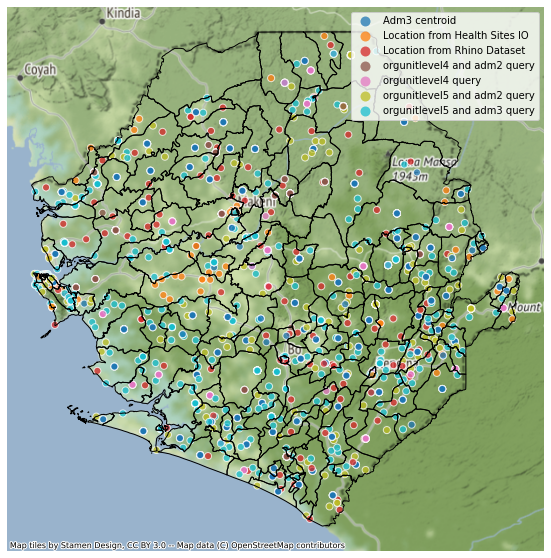

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
geob3.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from adminsitrative polygons

Join admin data back to results.  
For adm3 features, use spatial join to geob3.  

In [104]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [105]:
results2 = gpd.sjoin(results2, geob3[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

For adm2 features, use spatial join to geob2 first (excluding regions that were divided in 2017)  
Then use closest algorithm using FEWS NET adm 2 file.  
Ideally, we would just use the FEWS file, but it's resolution is not good enough to do intersects in border areas.

In [106]:
geob2_copy = geob2.copy()

In [107]:
idx_drop = geob2_copy.loc[geob2_copy.admin2Name.isin(['Bombali', 'Koinadugu'])].index

In [108]:
geob2_copy.drop(idx_drop, axis=0, inplace=True)

In [109]:
results2 = gpd.sjoin(results2, geob2_copy[["admin2Name", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [110]:
results2.loc[results2.admin2Name.isna(), "admin2Name"] = results2.loc[results2.admin2Name.isna()].apply(lambda x: match_to_closest(x, fews2, "ADMIN2"), axis=1)

In [111]:
results2.shapeName.isna().sum(), results2.admin2Name.isna().sum()

(0, 0)

In [121]:
# results2.loc[results2.adm3!=results2.shapeName]

In [128]:
results2.rename(
    columns={
        'shapeName':'geob_adm3',
        'shapeID':'geob_adm3_id',
        'admin2Name':'fews_adm2',
        'adm2':'fuzzy_match_adm2',
        'adm3':'fuzzy_match_adm3'
    }, inplace=True)

In [130]:
results2.to_file(join(output_dir, "SLE_geocoding_1.24.23.json"), driver='GeoJSON', index=True)

In [111]:
# geob3.to_file(join(output_dir, "SLE_geob3.json"), driver='GeoJSON')

In [132]:
results2.to_csv(join(output_dir, "SLE_geocoding_1.24.23.csv"))